In [163]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

In [164]:
from IPython.display import display


In [165]:
# 1. CONFIGURATION
# Define all paths upfront
DATA_PATH = Path(
    r"csv tables\transport_per_motive.csv")
OUTPUT_FOLDER_CSV = Path(
    r"csv tables")
OUTPUT_FOLDER_VIS = Path(
    r"visualisations")

# Ensure output folders exist
for folder in [OUTPUT_FOLDER_CSV, OUTPUT_FOLDER_VIS]:
    folder.mkdir(parents=True, exist_ok=True)

In [166]:
# 2. DATA PROCESSING

def load_and_clean_data(file_path):
    """Load and clean the raw data"""
    data = pd.read_csv(file_path)

    # Rename columns to english
    data.rename(columns={ 
    'Geslacht': 'Gender',
    'Leeftijd': 'Age',
    'Vervoerwijzen': 'Mode of transport',
    'Reismotieven': 'Travel motives',
    'Marges': 'Margins',
    'Perioden': 'Year',
    'Ritten per persoon per dag (gemiddeld) (aantal)': 'Average trips per person per day',
    'Afgelegde afstand per rit (gemiddeld) (km)': 'Average travel distance per trip (km)',
    'Reisduur per rit (Minuten)': 'Average traveltime per tip (minutes)',
    }, inplace=True)

    # Remove unnecessary columns
    data.drop(columns=['Mode of transport'], inplace=True)
    data.drop(columns=['Year'], inplace=True)

    # Filter only 'Value' rows
    bicycle_data = data[data['Margins'] == 'Waarde'].copy()

    # Convert European number formats
    numeric_cols = [
       'Average trips per person per day',
       'Average travel distance per trip (km)',
        'Average traveltime per tip (minutes)',
    ]

    for col in numeric_cols:
        bicycle_data[col] = (
            bicycle_data[col]
            .astype(str)
            .str.replace(',', '.')
            .astype(float)
        )


    return bicycle_data

In [176]:
# One hot encoding for categorical variables
def one_hot_encode(data, column):
   encoder = OneHotEncoder(sparse_output=False) # Initialise the encoder

   one_hot_encoded = encoder.fit_transform(data[[column]]) # Fit the encder to the data and transform it

   one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(), index=data.index) # Create a DataFrame from the encoded data

   df_encoded = pd.concat([data, one_hot_df], axis=1).dropna() # Concatenate the original DataFrame with the one-hot encoded DataFrame

   df_encoded = df_encoded.drop(columns=[column]) # Drop the original column after encoding
   return df_encoded # Return the DataFrame with the one-hot encoded columns

bicycle_data = load_and_clean_data(DATA_PATH) 
travel__one_hot = one_hot_encode(bicycle_data, 'Travel motives') # One-hot encode the 'Travel motives' column


In [177]:
# 3. LINEAR REGRESSION

# Define predictors (all one-hot columns starting with 'Travel motives_')
X = travel__one_hot.filter(like='Travel motives_')

# Define response variable
y = travel__one_hot['Average travel distance per trip (km)']

# Add constant to the model (for intercept)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Print model summary
print(model.summary())


                                      OLS Regression Results                                     
Dep. Variable:     Average travel distance per trip (km)   R-squared:                       0.550
Model:                                               OLS   Adj. R-squared:                  0.467
Method:                                    Least Squares   F-statistic:                     6.609
Date:                                   Thu, 15 May 2025   Prob (F-statistic):           0.000389
Time:                                           03:38:49   Log-Likelihood:                -30.230
No. Observations:                                     33   AIC:                             72.46
Df Residuals:                                         27   BIC:                             81.44
Df Model:                                              5                                         
Covariance Type:                               nonrobust                                         
                    

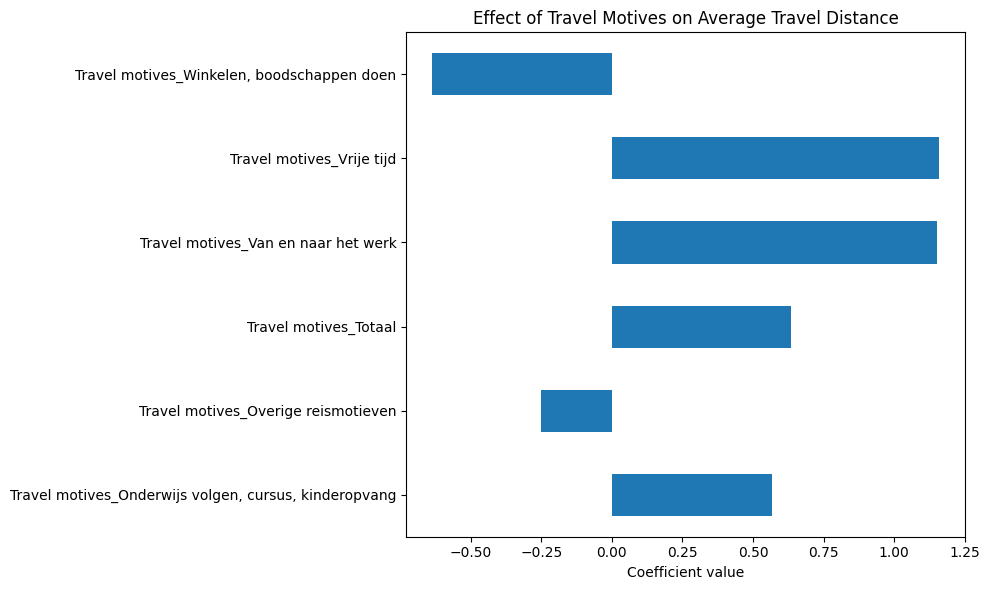

In [178]:
# Visualize regression coefficients
coef = model.params.drop('const')  # exclude intercept
coef.plot(kind='barh', figsize=(10, 6), title='Effect of Travel Motives on Average Travel Distance')
plt.xlabel('Coefficient value')
plt.tight_layout()
plt.show()


In [170]:
def lin_regression(data, X, y):
    X = pd.get_dummies(X, drop_first=True)
    X = sm.add_constant(X)  # Add a constant term to the predictor
    print(X)
    model = sm.OLS(y, X).fit()

    return model.summary()


In [171]:
bicycle_data = load_and_clean_data(DATA_PATH)
print(bicycle_data['Travel motives'].unique())
bicycle_data['Travel motives'] = bicycle_data['Travel motives'].astype(str).str.strip()


['Totaal' 'Van en naar het werk' 'Winkelen, boodschappen doen'
 'Onderwijs volgen, cursus, kinderopvang' 'Vrije tijd'
 'Overige reismotieven']


In [172]:
from sklearn.preprocessing import OneHotEncoder
bicycle_data = load_and_clean_data(DATA_PATH)

encoder = OneHotEncoder(sparse_output=False)

# Fit-transform on correct shape
one_hot_encoded = encoder.fit_transform(bicycle_data[['Travel motives']])

# Create dataframe for encoded features
one_hot_df = pd.DataFrame(
    one_hot_encoded,
    columns=encoder.get_feature_names_out(),
    index=bicycle_data.index
)

# Combine original and encoded data
df_encoded = pd.concat([bicycle_data, one_hot_df], axis=1)

# Correct column drop
df_encoded = df_encoded.drop(columns=['Travel motives'])

# Check output
print(df_encoded.head())


                      Gender     Age Margins  \
0   Totaal mannen en vrouwen  Totaal  Waarde   
3   Totaal mannen en vrouwen  Totaal  Waarde   
6   Totaal mannen en vrouwen  Totaal  Waarde   
9   Totaal mannen en vrouwen  Totaal  Waarde   
12  Totaal mannen en vrouwen  Totaal  Waarde   

    Average trips per person per day  Average travel distance per trip (km)  \
0                               0.78                                   3.75   
3                               0.14                                   4.22   
6                               0.17                                   2.09   
9                               0.11                                   3.36   
12                              0.27                                   5.20   

    Average traveltime per tip (minutes)  \
0                                  20.82   
3                                  18.61   
6                                  12.00   
9                                  17.48   
12              

In [173]:
bicycle_data = load_and_clean_data(DATA_PATH)
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False) # Initialize the encoder

one_hot_encoded = encoder.fit_transform(bicycle_data[['Travel motives']]) # Fit the encoder to the data and transform it

one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(), index=bicycle_data.index) # Create a DataFrame from the encoded data

df_encoded = pd.concat([bicycle_data, one_hot_df], axis=1) #

df_encoded = df_encoded.drop(columns=['Travel motives'])

print(df_encoded.columns.tolist())


print(f"Encoded Employee data : \n{df_encoded.head()}")

# X = bicycle_data['Travel motives'] 
# encoded = pd.get_dummies(bicycle_data, columns=['Travel motives'], drop_first=True) # Convert categorical variables to dummy/indicator variables
# print(encoded)
# X = sm.add_constant(X)  # Add a constant term to the predictor
# y = bicycle_data['Average travel distance per trip (km)']  # The response variable
# # Fit the model
# model = sm.OLS(y, X).fit()
# # Print the summary statistics of the model
# print(model.summary())
# print(X)

['Gender', 'Age', 'Margins', 'Average trips per person per day', 'Average travel distance per trip (km)', 'Average traveltime per tip (minutes)', 'Travel motives_Onderwijs volgen, cursus, kinderopvang', 'Travel motives_Overige reismotieven', 'Travel motives_Totaal', 'Travel motives_Van en naar het werk', 'Travel motives_Vrije tijd', 'Travel motives_Winkelen, boodschappen doen']
Encoded Employee data : 
                      Gender     Age Margins  \
0   Totaal mannen en vrouwen  Totaal  Waarde   
3   Totaal mannen en vrouwen  Totaal  Waarde   
6   Totaal mannen en vrouwen  Totaal  Waarde   
9   Totaal mannen en vrouwen  Totaal  Waarde   
12  Totaal mannen en vrouwen  Totaal  Waarde   

    Average trips per person per day  Average travel distance per trip (km)  \
0                               0.78                                   3.75   
3                               0.14                                   4.22   
6                               0.17                                

In [174]:
# def lin_regression(data, x_col, y_col):
#     """Perform linear regression and return the model summary"""
#     X = sm.add_constant(data[x_col])
#     y = data[y_col]
#     model = sm.OLS(y, X).fit()
#     return model.summary()

def lin_regression(data, X, y):
    X = pd.get_dummies(X, drop_first=True)
    X = sm.add_constant(X)  # Add a constant term to the predictor
    print(X)
    model = sm.OLS(y, X).fit()

    return model.summary()

In [175]:
bicycle_data = load_and_clean_data(DATA_PATH)
display(bicycle_data.tail())

lin_regression_conclusion = lin_regression(bicycle_data, 'Travel motives', 'Average travel distance per trip (km)')

,Gender,Age,Travel motives,Margins,Average trips per person per day,Average travel distance per trip (km),Average traveltime per tip (minutes)
87,Totaal mannen en vrouwen,25 tot 30 jaar,Overige reismotieven,Waarde,0.07,2.55,14.15
90,Totaal mannen en vrouwen,30 tot 40 jaar,Totaal,Waarde,0.69,3.29,18.28
93,Totaal mannen en vrouwen,30 tot 40 jaar,Van en naar het werk,Waarde,0.17,4.35,19.26
96,Totaal mannen en vrouwen,30 tot 40 jaar,"Winkelen, boodschappen doen",Waarde,0.13,1.91,11.32
99,Totaal mannen en vrouwen,30 tot 40 jaar,"Onderwijs volgen, cursus, kinderopvang",Waarde,0.01,3.04,16.92


    const
0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0


TypeError: len() of unsized object